<h1 align='center'>Projet Leyenda - Livrable 3 - Captioning</h1>
<h3 align='center'>Youssef AYARI, Matthieu DECLERCQ, Thomas PETAIN, Julien BARON, Jean-Baptiste CASTELLANI</h1>

L'objectif de de ce workshop est de vous faire acquérir les notions nécessaires pour effectuer le workshop d'[annotation d'images](https://fr.wikipedia.org/wiki/Annotation_automatique_d%27images) (ou sous-titrage d'images). Dans ce workshop, vous allez devoir utiliser les CNNs (pour création d’attributs utiles à l’annotation) ainsi que les RNNs (pour faire l’annotation à proprement parler). Vous allez aussi devoir faire **beaucoup** de prétraitements. Ce workshop portera essentiellement sur cette partie et donnera des indications sur l'architecture du réseau qui servira à faire de l'annotation. On commencera d'abord par importer les bibliothèques qui nous intéressent.

Vous devez, donc, ré-exécuter les cellules correspondant à la préparation des données du workshop précédent en allant du chargement des données jusqu'au prétraitements des images et des annotations.
<br><br>
<b>Imports</b>

In [1]:
import tensorflow as tf
import pathlib
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm

import json

Variables

In [2]:
image_h = 256
image_w = 256

<b>Chargement des données</b>

2000
<start> A zebra next to giraffes in an enclosure <end>


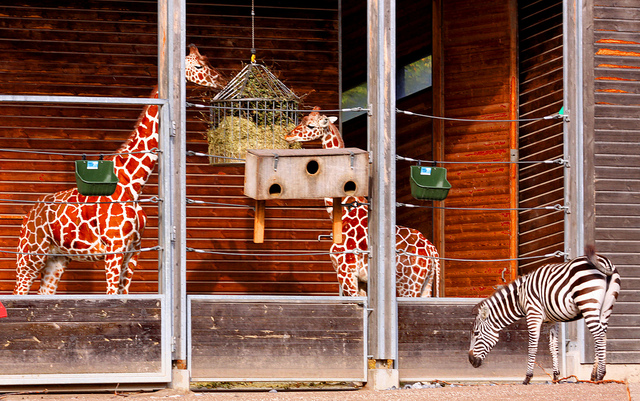

In [3]:
# Chemin du fichier d'annotations
annotation_file = os.path.abspath('.')+"/annotations/captions_train2017.json"

# Chemin du dossier contenant les images à annoter
image_folder = '/train2017/'
PATH = os.path.abspath('.') + image_folder

# Lecture du fichier d'annotation
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Grouper toutes les annotations ayant le meme identifiant.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    # marquer le debut et la fin de chaque annotation
    caption = f"<start> {val['caption']} <end>"
    # L'identifiant d'une image fait partie de son chemin d'accès
    # image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    image_path = PATH + '%012d.jpg' % (val['image_id'])
    # Rajout du caption associé à image_path
    image_path_to_caption[image_path].append(caption)
    
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:100000]
print(len(train_image_paths))

# Liste de toutes les annotations
train_captions = []
# Liste de tous les noms de fichiers des images dupliquées (en nombre d'annotations par image)
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    # Rajout de caption_list dans train_captions
    train_captions.extend(caption_list)
    # Rajout de image_path dupliquée len(caption_list) fois
    img_name_vector.extend([image_path] * len(caption_list))

print(train_captions[0])
Image.open(img_name_vector[0])


In [4]:
len(image_paths)

118287

In [5]:
# Définition de la fonction load_image
def load_image(image_path):
    """
    La fonction load_image a pour entrée le chemin d'une image et pour sortie un couple
    contenant l'image traitée ainsi que son chemin d'accès.
    La fonction load_image effectue les traitement suivant:
        1. Chargement du fichier correspondant au chemin d'accès image_path
        2. Décodage de l'image en RGB.
        3. Redimensionnement de l'image en taille (299, 299).
        4. Normalisation des pîxels de l'image entre -1 et 1
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [6]:
# Telechargement du modèle InceptionV3 pré-entrainé avec la cassification sur ImageNet
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
# Creation d'une variable qui sera l'entrée du nouveau modèle de pre-traitement d'images
new_input = image_model.input

# récupérer la dernière couche caché qui contient l'image en representation compacte
hidden_layer = image_model.layers[-1].output

# Modèle qui calcule une representation dense des images avec InceptionV3
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [7]:
# Pré-traitement des images
# Prendre les noms des images
encode_train = sorted(set(img_name_vector))

# Creation d'une instance de "tf.data.Dataset" partant des noms des images 
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# Division du données en batchs après application du pré-traitement fait par load_image
image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Parcourir le dataset batch par batch pour effectuez le pré-traitement d'InceptionV3
for img, path in tqdm(image_dataset):
    # Pré-traitement du batch (de taille (16,8,8,2048)) courant par InceptionV3 
    batch_features = image_features_extract_model(img)
    # Resize du batch de taille (16,8,8,2048) en taille (16,64,2048)
    batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1, batch_features.shape[3]))
    # Parcourir le batch courant et stocker le chemin ainsi que le batch avec np.save()
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        # (chemin de l'image associe a sa nouvelle representation , representation de l'image)
        np.save(path_of_feature, bf.numpy())

100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:54<00:00,  2.31it/s]


**Pré-traitement des annotations**

In [8]:
# Trouver la taille maximale 
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Chosir les 5000 mots les plus frequents du vocabulaire
top_k = 1500
#La classe Tokenizer permet de faire du pre-traitement de texte pour reseau de neurones 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                    oov_token="<unk>",
                                                    filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
# Construit un vocabulaire en se basant sur la liste train_captions
tokenizer.fit_on_texts(train_captions)

# Créer le token qui sert à remplir les annotations pour egaliser leurs longueur
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Creation des vecteurs(liste de token entiers) à partir des annotations (liste de mots)
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Remplir chaque vecteur à jusqu'à la longueur maximale des annotations
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calcule la longueur maximale qui est utilisée pour stocker les poids d'attention 
# Elle servira plus tard pour l'affichage lors de l'évaluation
max_length = calc_max_length(train_seqs)

# 1 Formation du jeu d'entrainement et de test :
Vous devez ensuite séparer le dataset en deux partie : un jeu d'entrainement et un jeu de test. Le code qui effectue ces opérations est détaillé dans la cellule suivante.

In [9]:
img_to_cap_vector = collections.defaultdict(list)
# Creation d'un dictionnaire associant les chemins des images avec (fichier .npy) aux annotationss
# Les images sont dupliquées car il y a plusieurs annotations par image
print(len(img_name_vector), len(cap_vector))
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

"""
Création des datasets de formation et de validation en utilisant 
un fractionnement 80-20 de manière aléatoire
""" 
# Prendre les clés (noms des fichiers d'images traites), *celles-ci ne seront pas dupliquées*
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)
# Diviser des indices en entrainement et test
slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

"""
Les jeux d'entrainement et de tests sont sous forme
de listes contenants les mappings :(image prétraitée ---> jeton d'annotation(mot) )
"""

# Boucle pour construire le jeu d'entrainement
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    # Duplication des images en le nombre d'annotations par image
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

# Boucle pour construire le jeu de test
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    # Duplication des images en le nombre d'annotations par image
    cap_val.extend(img_to_cap_vector[imgv])

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

10013 10013


(8011, 8011, 2002, 2002)

Création d’un jeu de données d’entrainement représenté par une instance [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) partant du jeu de données de base (les noms des fichiers et des annotations du jeu d’entrainement). La classe `tf.data.Dataset` sert à représenter des jeu de données volumineux et facilitent les prétraitements de ceux-ci.

In [10]:
# N'hésitez pas à modifier ces paramètres en fonction de votre machine
BATCH_SIZE = 64 # taille du batch
BUFFER_SIZE = 1000 # taille du buffer pour melanger les donnes
embedding_dim = 256
units = 512 # Taille de la couche caché dans le RNN
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# La forme du vecteur extrait à partir d'InceptionV3 est (64, 2048)
# Les deux variables suivantes representent la forme de ce vecteur
features_shape = 2048
attention_features_shape = 64

# Fonction qui charge les fichiers numpy des images prétraitées
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

# Creation d'un dataset de "Tensor"s (sert à representer de grands dataset)
# Le dataset est cree a partir de "img_name_train" et "cap_train"
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# L'utilisation de map permet de charger les fichiers numpy (possiblement en parallèle)
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Melanger les donnees et les diviser en batchs
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# 2 Le modèle :
Par rapport au modèle, la dernière couche convolutive d'`InceptionV3` est de la forme `(8, 8, 2048)`. Ce vecteur a été remodelé en la forme `(64, 2048)` lors de du stockage au niveau du disque. Ce vecteur est ensuite passé à travers l'encodeur CNN (qui se compose d'une seule couche entièrement connectée). Le RNN s'occupera de prédire pour ce vecteur le mot suivant dans l'annotation. [L'image](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/22_Image_Captioning.ipynb) ci-dessous reprend un exemple d'une architecture très basique d'un système d'annotation utilisant un CNN et un RNN.

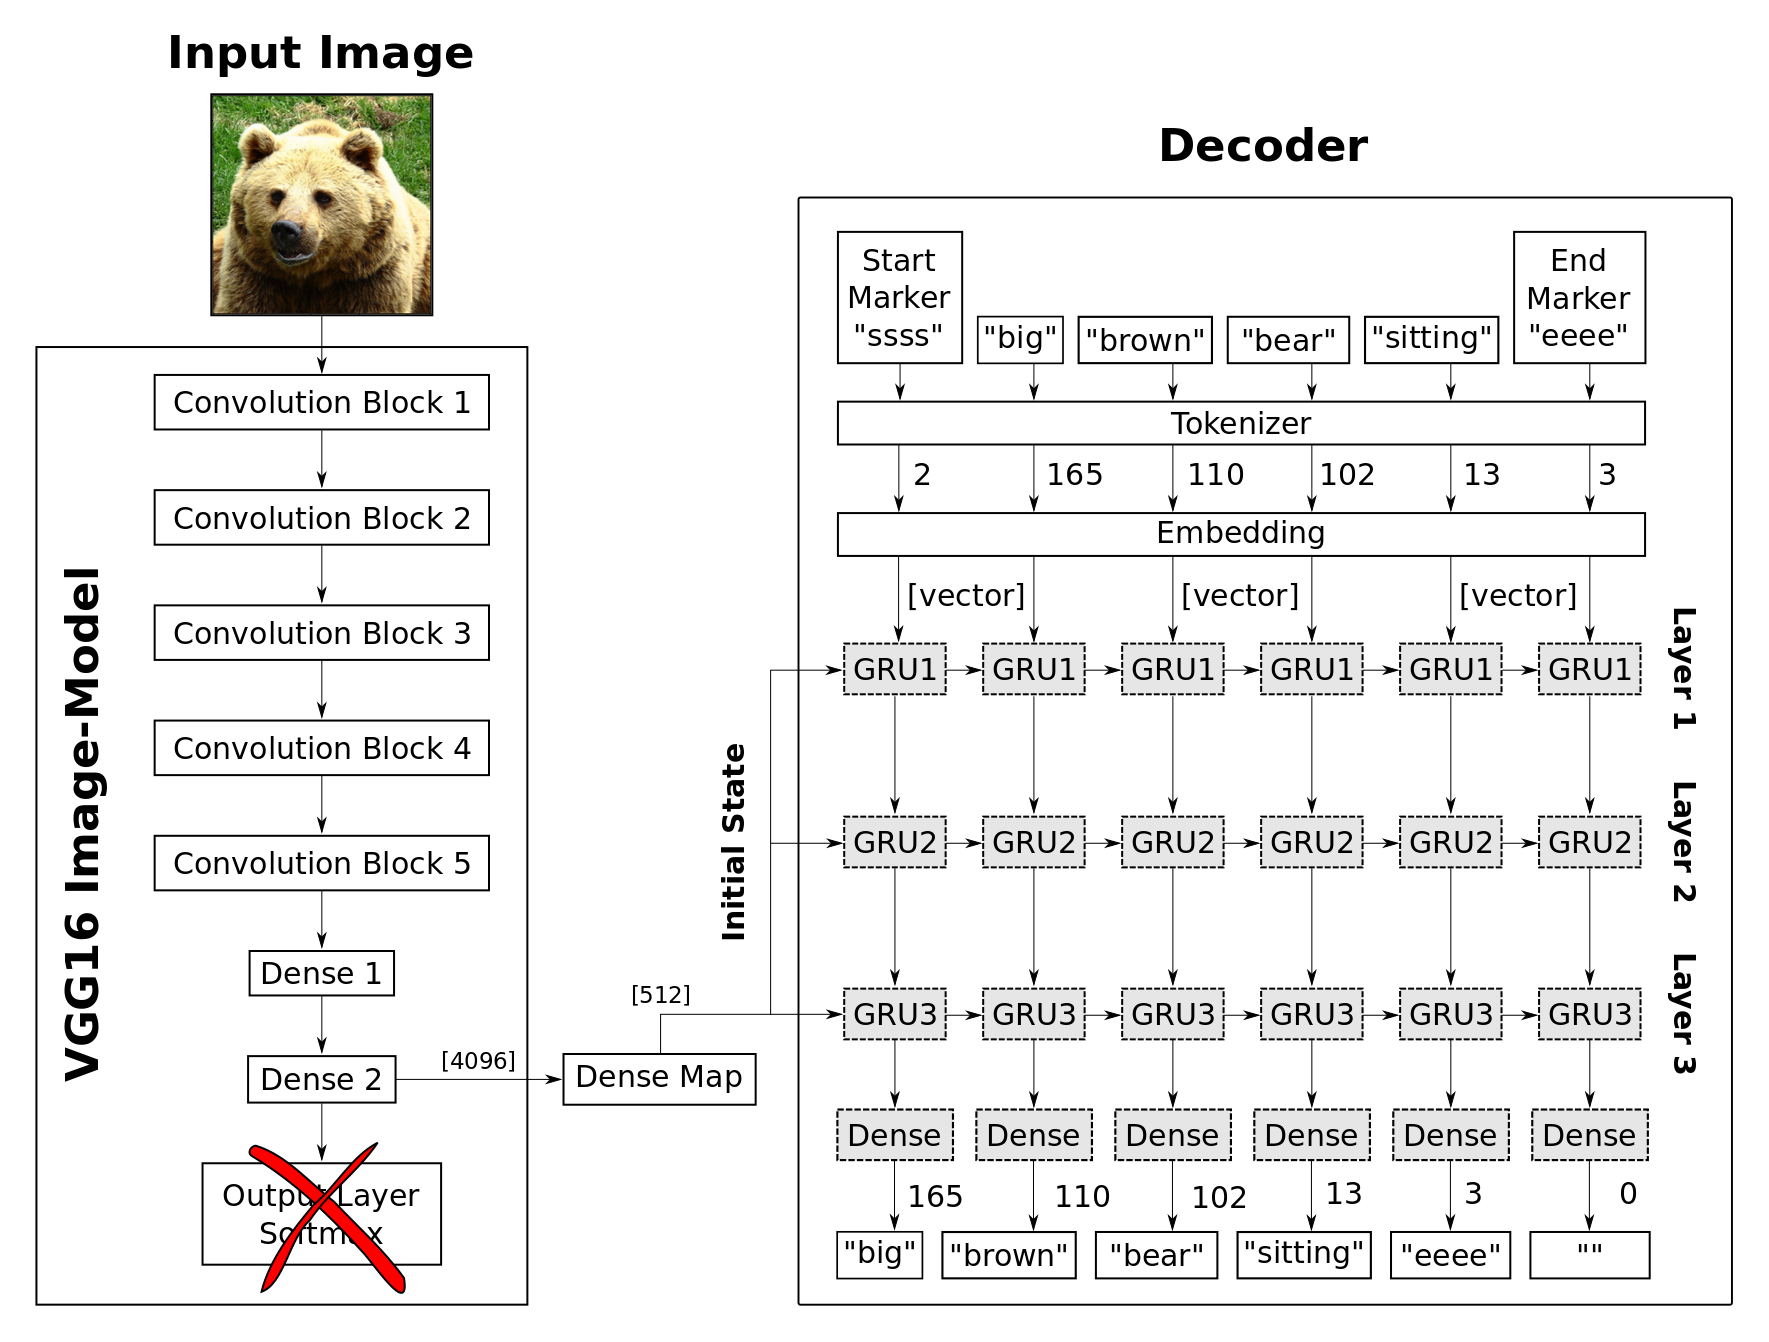

Dans cet exemple le captioning se fait de cette façon:
<ul>
    <li>L'image est passée à travers le CNN pour avoir une représentation compacte de celui-ci. Cette représentation est retournée par la couche `Dense 2` de taille 4096.</li>
    <li>Cette représentation est réduite en la passant à la couche dense `Dense Map` pour etre mise en entrée comme etat caché initial aux cellules du RNN.</li>
    <li>La partie RNN est composée de <a href="https://openclassrooms.com">GRU</a> (Gated Reccurent Unit). Cette partie est constituée de 3 couches. Une couche représentant de manière assez sommaire un niveau d'abstraction du langage. </li>
    <li>Le RNN a en entrée l'annotation ainsi que l'image en forme compacte, et retourne pour chaque colonne le mot suivant le mot en entrée au niveau de la colonne.</li>
    <li>Les annotations sont représentées en liste de mot. Cette liste est inexploitable par le RNN, elle est donc passée à un module qui remplace chaque mot par un entier (ou jeton entier), puis par un autre module qui projette chaque jeton en un vecteur dont les éléments sont entre -1 et 1.</li>
</ul>

Votre système d'annotation suivra de manière assez globale, le même principe que montrée dans l'image ci-dessous, néanmoins il contiendra des différences essentielles le distinguant de cet exemple. La système contiendra, notamment, un mécanisme d'attention (expliqué dans [article](https://arxiv.org/pdf/1502.03044.pdf) et dans [la video](https://www.youtube.com/watch?v=uCSTpOLMC48&list=WL&index=257)) dont la fonction est d'amener le réseau de neurones à donner une plus grande importance dans ses prédictions de l'annotation aux parties de l'images les plus parlantes et les plus pertinentes.

**L'encodeur CNN :**

L'encodeur CNN produit une représentation adéquate de l'image qu'il transmet au décodeur RNN pour la légender. Le CNN a en entrée les caractéristiques des images déjà prétraitées par InceptionV3 et stockées sur disque. 

Petite remarque, dans la partie CNN de ce réseau de neurones, la dernière couche convolutive n’est pas aplatie comme dans le cas du précédent workshop sur les CNNs. Rappelez-vous que les images issues du prétraitement par InceptionV3 étaient de la forme 8x8x2048. Ces images ont été remodelées pour avoir la taille 64x2048. Cela signifie que cette représentation contient pour chacune des 64 positions de l’image prétraitée les 2048 caractéristiques extraites par InveptoinV3. Et donc, l’entrée du décodeur CNN est un batch ou chaque élément est constitué des 2048 caractéristiques des 64 positions de l’image prétraitée (qui était à l’origine 8x8). La couche dense qui suit calcule une nouvelle représentation de l’image de taille 64x256 ou chaque position de l’image a donc 256 caractéristiques. Les poids sont les mêmes pour les neurones de mêmes position qui se trouvent sur la même colonne dans l’image prétraitée (qui sont associées à la même caractéristique de l’image). Ceci provient de la manière qu’a la [couche dense]( https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) de gérer les opérations matricielles dans tensorflow.

L’avantage de cette représentation par rapport à la représentation aplatie est de préserver de l’information spatiale au niveau des couches du réseau de neurones. Ceci permettra au mécanisme d’attention de la partie RNN de détecter les positions intéressantes au niveau de l’image et de renseigner l’algorithme sur quelle zone il devra porter le plus d’importance pour légender l’image.

In [11]:
class CNN_Encoder(tf.keras.Model):
    # Comme les images sont déjà prétraités par InceptionV3 est représenté sous forme compacte
    # L'encodeur CNN ne fera que transmettre ces caractéristiques à une couche dense
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # forme après fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

**Le mécanisme d'attention :**

Le mécanisme d’attention ressemble beaucoup à une cellule [RNN classique]( https://fr.wikipedia.org/wiki/R%C3%A9seau_de_neurones_r%C3%A9currents), mais avec quelques différences. La partie de l’attention a en entrée la représentation de l’image prétraitée retournée par le CNN ainsi que la valeur courante de l’état cachée du GRU, et en sortie le **vecteur du contexte** qui reflète les caractéristiques les plus importantes de l’image. Une étape intermédiaire pour calculer ce vecteur consiste à calculer les **poids d’attention** qui représentent l’importance de chaque position de l’image (il y en a 64) dans la prédiction de son annotation.

La représentation de l’image donnée en entrée est transformée au début de la même manière que pour le CNN en la passant à une couche dense de taille `units`. De même, l’état caché est aussi passé à une couche dense de taille `units`. La nouvelle représentation de l’image est ensuite additionnée à l’état caché puis passée à une fonction d’activation de type [`tanh`](https://fr.wikipedia.org/wiki/Tangente_hyperbolique) comme pour les cellules classiques de RNN. À ce niveau-là, on aura une représentation des données de taille `64xunits` contenant un mélange d’informations sur l’image et sur le texte de l’annotation. Un score est ensuite associé à chacune des positions en passant cette représentation à une couche dense. Ces scores sont normalisés avec une couche softmax pour produire le vecteur des **poids d’attention**. 

Finalement, chaque caractéristique de la représentation de l’image en entrée sera multipliée (pondérée) par le vecteur d’attention. Après quoi, on prend la somme de chaque caractéristique le long des positions (les lignes de la représentation) pour former le **vecteur du contexte**.

De façon globale, on peut dire que le vecteur d’attention dépend de scores qui sont appris à partir d’une représentation spatiale et textuelle de l’image. Ce vecteur d’attention renvoie la pertinence de chaque position et sert à calculer le vecteur du contexte qui nous donnera l’importance des caractéristiques de l’image.

In [12]:
class BahdanauAttention(tf.keras.Model):
        def __init__(self, units):
                super(BahdanauAttention, self).__init__()
                self.W1 = tf.keras.layers.Dense(units)
                self.W2 = tf.keras.layers.Dense(units)
                self.V = tf.keras.layers.Dense(1)

        def call(self, features, hidden):
                # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

                # hidden shape == (batch_size, hidden_size)
                # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
                hidden_with_time_axis = tf.expand_dims(hidden, 1)
                
                # attention_hidden_layer shape == (batch_size, 64, units)
                attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                                        self.W2(hidden_with_time_axis)))
                # score shape == (batch_size, 64, 1)
                # This gives you an unnormalized score for each image feature.
                score = self.V(attention_hidden_layer)

                # attention_weights shape == (batch_size, 64, 1)
                attention_weights = tf.nn.softmax(score, axis=1)

                # context_vector shape after sum == (batch_size, hidden_size)
                context_vector = attention_weights * features
                context_vector = tf.reduce_sum(context_vector, axis=1)

                return context_vector, attention_weights

**Le décodeur RNN :**

Le rôle du décodeur RNN est d’utiliser la représentation prétraitée de l’image de prédire sa légende mot par mot. Ce RNN à une seule cellule de type [GRU]( https://en.wikipedia.org/wiki/Gated_recurrent_unit). Le GRU a un état caché qui représente la mémoire des derniers éléments vu par celui-ci. Le GRU met à jour son état avant de le retourner, pour cela il utilise certains mécanismes de mémorisation qui sont assez sophistiqués.

Le décodeur est structuré comme suit, à chaque appel du RNN, le mot courant ainsi que la représentation de l’image et l’état caché du GRU sont donnés en entrée du RNN. Comme les mots sont représentés par des entiers, on doit faire passer ceux-ci par une couche dite [embedding layer]( https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) qui se chargera de calculer une représentation vectorielle de taille `output_dim` partant du nombre représentant le mot. 

À côté de ça, le mécanisme d’attention fournit un vecteur représentant **le contexte** de l’image c-à-d un vecteur qui nous renseigne sur les caractéristiques dominantes de l’image. Ce vecteur est calculé par un appel du mécanisme d’attention en lui fournissant en entrée les caractéristiques de l’image encodées par le CNN ainsi que l’état caché du GRU qui résume l’historique des mots vues par le RNN jusqu’à présent. 

Ensuite, le mot courant et le contexte sont concaténée pour former le vecteur d’entrée du GRU qui à son tour calcule l’état à l’étape suivante. Cet état est passée par une couche dense de taille `units` puis la sortie de cette couche est passée à une autre couche dense de taille `vocab_size` qui retourne le score associé à chaque mot du vocabulaire afin de prédire le mot suivant.

In [13]:
class RNN_Decoder(tf.keras.Model):
        def __init__(self, embedding_dim, units, vocab_size):
                super(RNN_Decoder, self).__init__()
                self.units = units
                self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
                self.gru = tf.keras.layers.GRU(self.units,
                                        return_sequences=True,
                                        return_state=True,
                                        recurrent_initializer='glorot_uniform')
                #Couche dense qui aura pour entrée la sortie du GRU
                self.fc1 = tf.keras.layers.Dense(self.units)
                # Dernière couche dense
                self.fc2 = tf.keras.layers.Dense(vocab_size)
                self.attention = BahdanauAttention(self.units)

        def call(self, x, features, hidden):
                # L'attention est defini par un modèle a part
                context_vector, attention_weights = self.attention(features, hidden)
                # Passage du mot courant à la couche embedding
                x = self.embedding(x)
                # Concaténation
                x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
                # Passage du vecteur concaténé à la gru
                output, state = self.gru(x)
                # Couche dense
                x = self.fc1(output)
                x = tf.reshape(x, (-1, x.shape[2]))
                # Couche dense
                x = self.fc2(x)
        
                return x, state, attention_weights
        def reset_state(self, batch_size):
                return tf.zeros((batch_size, self.units))

**Combiner la partie encodeur et décodeur :**

Vous devez compléter la partie du code pour la création de l'encodeur et du décodeur.

In [14]:
# Création de l'encodeur
encoder = CNN_Encoder(embedding_dim)
# Création du décodeur
decoder = RNN_Decoder(embedding_dim, units, vocab_size)


In [15]:
# Optimiseur ADAM
optimizer = tf.keras.optimizers.Adam()
# La fonction de perte
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

Pour garder la trace de votre apprentissage et la sauvegarder, vous pouvez utiliser la classe [`tf.train.Checkpoint`](https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint).

In [16]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

Initialisation de l'époque de début d’entrainement dans `start_epoch`. La classe `tf.train.Checkpoint` permet de poursuivre l’entrainement là ou vous l’avez laissé s’il avait été interrompu auparavant.

In [17]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # Restaurer le dernier checkpoint dans checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

# 3 Entrainement et test :
Vous implémenterez ensuite les fonctions `train_step` et `evaluate` :

- La fonction `train_step` représente une étape de l'entrainement du réseau. Elle est composée de l'évaluation par l'encodeur du vecteur pré-calculé par InceptionV3. La sortie de cette étape sera transmise au décodeur qui se charge de prédire l'annotation mot par mot. La boucle pour prédire chaque mot et calculer la perte associée devra être implémenté dans cette fonction.
- La fonction `evaluate` servira à évaluer les performances du réseau sur le jeu de test. Elle est donc similaire à la fonction `train_step` sauf que la partie calcul de la fonction de perte est absente car il n'agit pas d'entrainer le réseau.</li>

Enfin, vous devez implémenter la partie du code qui fait l'entrainement et le test. Précisons que l'entrainement se fait ici par batch d'images.

# 3.1 Entrainement
La fonction qui permet d'achever une étape d'entrainement sur un batch d'images est `train_step`. La fonction a en entrée un batch d'images prétraitées ainsi que leurs annotations et retourne la perte associée à ce batch. 

L'état caché de la partie RNN est initialisé ainsi que le mot de départ avec le token de début. Les caractéristiques de l'image sont ensuite extraites par l’encodeur. Après cela, on parcourt le batch mot par mot pour prédire le mot suivant à l'aide du décodeur. Le décodeur utilise l'état caché, les caractéristiques de l'image ainsi que le mot précédent pour prédire le mot courant. Le décodeur met à jour l'état caché et le retourne ainsi que les prédictions du batch. La perte est calculée à partir des prédictions retournées par le décodeur et les annotations associées au batch.

Finalement, la perte globale ainsi que le gradient sont calculés et le réseau est mis à jour.

In [18]:
loss_plot = []
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # Initialisation de l'état caché pour chaque batch
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    # Initialiser l'entrée du décodeur
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: # Offre la possibilité de calculer le gradient du loss
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Prédiction des i'èmes mot du batch avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # Le mot correct à l'étap i est donné en entrée à l'étape (i+1)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

Le code global contenant la boucle d'entrainement est présenté ci-dessous. Cette boucle parcours le jeu de données d'entrainement batch par batch et entraine le réseaux avec ceux-ci.

Epoch 2 Batch 0 Loss 1.8066
Epoch 2 Batch 100 Loss 1.0100
Epoch 2 Loss 1.191055
Time taken for 1 epoch 80.27083849906921 sec

Epoch 3 Batch 0 Loss 0.9645
Epoch 3 Batch 100 Loss 0.8428
Epoch 3 Loss 0.907192
Time taken for 1 epoch 23.54805636405945 sec



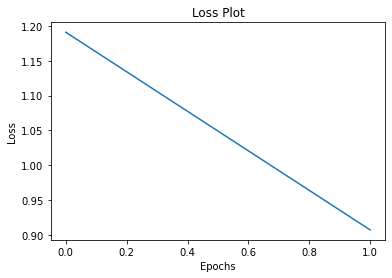

In [19]:
EPOCHS = 40

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # sauvegarde de la perte
    loss_plot.append(total_loss / num_steps)

    if epoch % 1 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

# Affichage de la courbe d'entrainement
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [20]:
decoder.save('models/livrable_3/caption')

INFO:tensorflow:Assets written to: models/livrable_3/caption\assets


INFO:tensorflow:Assets written to: models/livrable_3/caption\assets


# 4. Démonstration au client

## 4.1 Phase de classification

In [21]:
classification_dir = pathlib.Path('Classification')
class_test = ['Photo','Autre']

if os.path.exists(classification_dir) == False:
    os.mkdir(classification_dir)
    class_predict = map(lambda x: os.path.join(classification_dir, x), class_test)
    [os.mkdir(x) for x in class_predict]
    
def load_image_classification():
    #veuillez mettre le chemin d'accès de votre dossier contenant les images à classer dans la variable path_data 
    path_data = "C://Users//jbcst//OneDrive//Bureau//new" 
    onlyfiles = [os.path.join(path_data, f) for f in os.listdir(path_data) if os.path.isfile(os.path.join(path_data, f))]
    return onlyfiles

model_dir = pathlib.Path("models/livrable_1/classifieur")

model = keras.models.load_model(model_dir)
count = 0
list_file = load_image_classification()
for file in list_file:
    img = image.load_img(file, target_size=(180, 180))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images)
    if classes[0]<0.5:
        img.save("{path}//{name}.png".format(path = os.path.join(classification_dir, class_test[1]), name = file.split("\\")[1]), format='PNG')
    else:
        img.save("{path}//{name}.png".format(path = os.path.join(classification_dir, class_test[0]), name = file.split("\\")[1]), format='PNG')
    count+=1

## 4.2 Phase de débruitage

In [22]:
#Créer le fichier denoise 
path_denoise = pathlib.Path('Denoise')
if not os.path.exists(path_denoise):
    os.mkdir(path_denoise)
    
#Récupérer tous les fichiers de classification
def load_image_denoise(path_directory_load):
    onlyfiles = [os.path.join(path_directory_load, f) for f in os.listdir(path_directory_load) if os.path.isfile(os.path.join(path_directory_load, f))]
    return onlyfiles

def preprocess(data, is_batch = True):
    batch_size = len(data) if is_batch else 1
    data = np.array(data, dtype=np.float32) #Conversion de l'image en narray de nombre de flotan
    data = data.astype('float32') / 255.0 #Normalisation des données de narray
    data = np.reshape(data, (batch_size, image_h, image_w, 3))# redimensionnement de l'array
    return data

#Appliquer le débruitage sur chaque image et enregistrer le résultat
def save_predict(model_path, path_directory_load): 
    model = keras.models.load_model(model_path)
    list_file_from_directory = load_image_denoise(path_directory_load)
    count = 0
    for _,file in enumerate(list_file_from_directory):
        img = image.load_img(file, target_size=(256, 256))
        img_convert = preprocess(img, is_batch=False)
        model = tf.keras.models.load_model(model_path)
        predictions = model.predict(img_convert)
        convert_img = Image.fromarray((predictions[0] * 255).astype('uint8'))
        convert_img.save("{path}//{name}.png".format(path = 'Denoise', name = count), format='PNG')
        count += 1 

save_predict(r'models/livrable_2/Autoencodeur_improved/best.h5', r"Classification/Photo")

## 4.3 Phase de captioning

# 3.2 Test
La fonction qui permet d'achever une étape d'evaluation pour le test est dans la cellule suivante. 

In [23]:
model_caption_dir = pathlib.Path("models/livrable_3/caption")

caption_model = keras.models.load_model(model_caption_dir)

def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
#         predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        predictions, hidden, attention_weights = caption_model(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

# Fonction permettant la représentation de l'attention au niveau de l'image
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

L'affichage de quelques exemples sur le résultat retourné par l'évaluation. 

In [24]:
#Récupérer tous les fichiers de denoising
def load_image_caption(path_directory_load):
    onlyfiles = [os.path.join(path_directory_load, f) for f in os.listdir(path_directory_load) if os.path.isfile(os.path.join(path_directory_load, f))]
    return onlyfiles

In [25]:
# Affichage de quelques annotations dans le jeu de test
path_caption = pathlib.Path('Denoise')
list_file_from_noise_directory = load_image_caption(path_caption)

results = []

for _,file in enumerate(list_file_from_noise_directory):
        result, attention_plot = evaluate(file)
        str_result = ' '.join(result)
        str_full = "Chemin : " + file + " , description : " + str_result
        results.append(str_full)
#         results.append('Prediction Caption:', ' '.join(result))
        
#         print('Prediction Caption:', ' '.join(result))
#         plot_attention(file, result, attention_plot)
# print(results)
with open('results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

Try it on your own images
For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)